In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 14.7 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import pandas as pd
import re
import numpy as np
from ultralytics import YOLO
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
import warnings

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set Chinese font

# Define parameters
dataset_dir = r'dataset_fitness'  # Dataset directory, please modify according to the actual path
output_image_dir = 'output_images'  # Folder to save frame images
output_csv_path = 'output_keypoints_data.csv'  # CSV file to save joint data
os.makedirs(output_image_dir, exist_ok=True)


In [ ]:
# Define names for the 17 keypoints
KEYPOINT_NAMES = [
    "Nose", "Right Eye", "Left Eye", "Right Ear", "Left Ear",
    "Right Shoulder", "Left Shoulder", "Right Elbow", "Left Elbow",
    "Right Wrist", "Left Wrist", "Right Hip", "Left Hip",
    "Right Knee", "Left Knee", "Right Ankle", "Left Ankle"
]

# define key points to keep
keypoints_to_keep = [
    'Right Shoulder', 'Left Shoulder', 'Right Elbow', 'Left Elbow',
    'Right Wrist', 'Left Wrist', 'Right Hip', 'Left Hip',
    'Right Knee', 'Left Knee', 'Right Ankle', 'Left Ankle'
]


In [ ]:
# construct the column names to be processed
keypoint_columns = []
for kp in keypoints_to_keep:
    keypoint_columns.append(f'{kp}_x')
    keypoint_columns.append(f'{kp}_y')

In [ ]:
# Define a function to calculate the new origin and coordinate normalization
def calculate_new_origin(keypoints_data):
    right_shoulder = keypoints_data[5][:2]
    left_shoulder = keypoints_data[6][:2]
    right_hip = keypoints_data[11][:2]
    left_hip = keypoints_data[12][:2]

    valid_points = [p for p in [right_shoulder, left_shoulder, right_hip, left_hip] if p[0] != 0 and p[1] != 0]
    if len(valid_points) == 0:
        raise ValueError("Missing keypoints for right shoulder, left shoulder, right hip, and left hip, cannot calculate new origin")

    x0 = sum([p[0] for p in valid_points]) / len(valid_points)
    y0 = sum([p[1] for p in valid_points]) / len(valid_points)
    return x0, y0

def get_min_max_of_new_coords(keypoints_data, x0, y0):
    x_new_values = []
    y_new_values = []

    for keypoint in keypoints_data:
        x, y, conf = keypoint
        if conf > 0:  # Only compute valid keypoints
            x_new = x - x0
            y_new = -(y - y0)  # Y-axis grows from bottom to top
            x_new_values.append(x_new)
            y_new_values.append(y_new)

    x_min_new, x_max_new = min(x_new_values), max(x_new_values)
    y_min_new, y_max_new = min(y_new_values), max(y_new_values)

    return x_min_new, x_max_new, y_min_new, y_max_new

def parse_keypoints_with_custom_origin(results):
    parsed_keypoints_list = []
    for i in range(len(results)):
        keypoints_data = results[i].keypoints.data.cpu().numpy()[0]  # Retrieve keypoints (17, 3)

        # Calculate the new origin coordinates
        try:
            x0, y0 = calculate_new_origin(keypoints_data)
        except ValueError as e:
            print(f"Object {i} could not calculate a new origin: {e}")
            continue  # Skip this object

        # Calculate the min and max values of x_new and y_new in the new coordinate system
        x_min_new, x_max_new, y_min_new, y_max_new = get_min_max_of_new_coords(keypoints_data, x0, y0)

        object_keypoints = {"object_id": i}
        keypoint_dict = {}

        # Calculate each keypoint's coordinates relative to the new origin and normalize
        for j, keypoint in enumerate(keypoints_data):
            x, y, conf = keypoint
            if x == 0 and y == 0:
                keypoint_dict[KEYPOINT_NAMES[j]] = None
            else:
                # Coordinates in the new coordinate system, Y-axis grows from bottom to top
                x_new = x - x0
                y_new = -(y - y0)

                # Normalize the new coordinates
                if x_max_new != x_min_new:
                    x_normalized = (x_new - x_min_new) / (x_max_new - x_min_new)
                else:
                    x_normalized = 0  # Avoid division by zero if max equals min

                if y_max_new != y_min_new:
                    y_normalized = (y_new - y_min_new) / (y_max_new - y_min_new)
                else:
                    y_normalized = 0  # Avoid division by zero if max equals min

                keypoint_dict[KEYPOINT_NAMES[j]] = {
                    "name": KEYPOINT_NAMES[j],
                    "x": x_normalized,
                    "y": y_normalized,
                    "confidence": conf
                }

        object_keypoints["keypoints"] = keypoint_dict
        parsed_keypoints_list.append(object_keypoints)

    return parsed_keypoints_list


In [ ]:
# Initialize a list to store data
all_data = []

# Load the YOLOv8 pose model
model = YOLO('yolov8n-pose.pt')


100%|██████████| 6.52M/6.52M [00:00<00:00, 53.8MB/s]


In [ ]:
dataset_dir = '/content/drive/MyDrive/fitness/dataset_fitness/'
output_image_dir = '/content/drive/MyDrive/fitness/output_images/'
# Traverse the entire dataset_fitness directory to find all video files
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.MOV') or file.endswith('.mov'):  # Process video files
            input_video_path = os.path.join(root, file)
            # Output the currently processing video file
            print(f"Processing video: {input_video_path}")
            # Extract action name and standard type
            video_info = input_video_path.split(os.sep)[-2:]  # Extract the last two parts as the action name and standard type
            action_name = re.sub(r'^\d+\s*', '', video_info[0])  # Remove leading numbers and spaces
            standard_type = video_info[1].split('.')[0]

            # Open the video file
            cap = cv2.VideoCapture(input_video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = frame_count / fps

            # Take 5 frames every 0.5 seconds
            frames_per_half_second = int(fps / 2)
            max_duration = 3.0  # Only process the first 3 seconds of the video
            max_frame_to_process = int(fps * max_duration)

            frame_indices = []
            for i in range(0, max_frame_to_process, frames_per_half_second):
                # Select 3 frames from the 5-frame interval
                for j in [0, 2, 4]:  # Select the 1st, 3rd, and 5th frames from the 5 frames
                    frame_index = i + j
                    if frame_index < max_frame_to_process:
                        frame_indices.append(frame_index)

            frame_indices = sorted(set(frame_indices))  # Ensure no duplicate frames, sort in order

            # Process the video frame by frame
            frame_number = 0
            sequence_number = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_number in frame_indices:
                    # Use the model for detection
                    results = model(frame)
                    parsed_keypoints = parse_keypoints_with_custom_origin(results)

                    # Assign the same sequence number: frames within the same 0.5-second interval share the same sequence number
                    sequence_number = frame_number // frames_per_half_second

                    for obj in parsed_keypoints:
                        keypoints = obj['keypoints']
                        row_data = {
                            'action_name': action_name,
                            'standard_type': standard_type,
                            'frame_index': frame_number,
                            'sequence': sequence_number,
                        }
                        # Store the coordinates of each keypoint into row_data
                        for kp_name in KEYPOINT_NAMES:
                            kp_info = keypoints.get(kp_name, None)
                            if kp_info:
                                row_data[f'{kp_name}_x'] = kp_info['x']
                                row_data[f'{kp_name}_y'] = kp_info['y']
                            else:
                                row_data[f'{kp_name}_x'] = None
                                row_data[f'{kp_name}_y'] = None

                        all_data.append(row_data)

                    # Save the processed frame image
                    processed_frame = results[0].plot()

                    image_output_path = os.path.join(output_image_dir,
                                                     f"{action_name}_{standard_type}_{frame_number}_{sequence_number}.jpg")
                    cv2.imwrite(image_output_path, processed_frame)  # Save the detection result image

                frame_number += 1

            # Release video resources
            cap.release()


正在处理视频: /content/drive/MyDrive/fitness/dataset_fitness/13 Leg Press/nonstandard03.mov

0: 640x544 1 person, 271.6ms
Speed: 6.1ms preprocess, 271.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 363.6ms
Speed: 8.9ms preprocess, 363.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 267.8ms
Speed: 6.2ms preprocess, 267.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 450.9ms
Speed: 15.3ms preprocess, 450.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 371.5ms
Speed: 9.9ms preprocess, 371.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 405.3ms
Speed: 16.6ms preprocess, 405.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 person, 346.4ms
Speed: 10.7ms preprocess, 346.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 p

In [ ]:
# Convert all data into a DataFrame
columns = ['action_name', 'standard_type', 'frame_index', 'sequence'] + [f'{k}_x' for k in KEYPOINT_NAMES] + [f'{k}_y' for k in KEYPOINT_NAMES]
data = pd.DataFrame(all_data, columns=columns)

# Save data to a CSV file
output_csv_path = '/content/drive/MyDrive/fitness/output_keypoints_data.csv'  # Path to save in Google Drive
data.to_csv(output_csv_path, index=False)
print("Data extraction completed and saved to CSV file.")


数据提取完成并保存到 CSV 文件。


In [ ]:
# Data cleaning and mean imputation
# Use groupby to group by action_name and standard_type, and perform mean imputation for the coordinate columns within each group
data[keypoint_columns] = data.groupby(['action_name', 'standard_type'])[keypoint_columns].transform(
    lambda group: group.fillna(group.mean())
)

# Check if there are still missing values and handle any exceptional cases
if data[keypoint_columns].isnull().sum().sum() > 0:
    print("Some action_name and standard_type groups have a mean of NaN, further processing may be needed.")
else:
    print("All missing values have been successfully filled!")


所有空值已成功填充！


In [ ]:
# Prepare features and labels
features = keypoint_columns
X = data[features]  # Keypoint coordinates
y = data['action_name']  # Classification labels (action names)

# Encode category labels as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder
joblib.dump(label_encoder, 'action_label_encoder.pkl')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


KNN 动作分类的准确率: 0.99


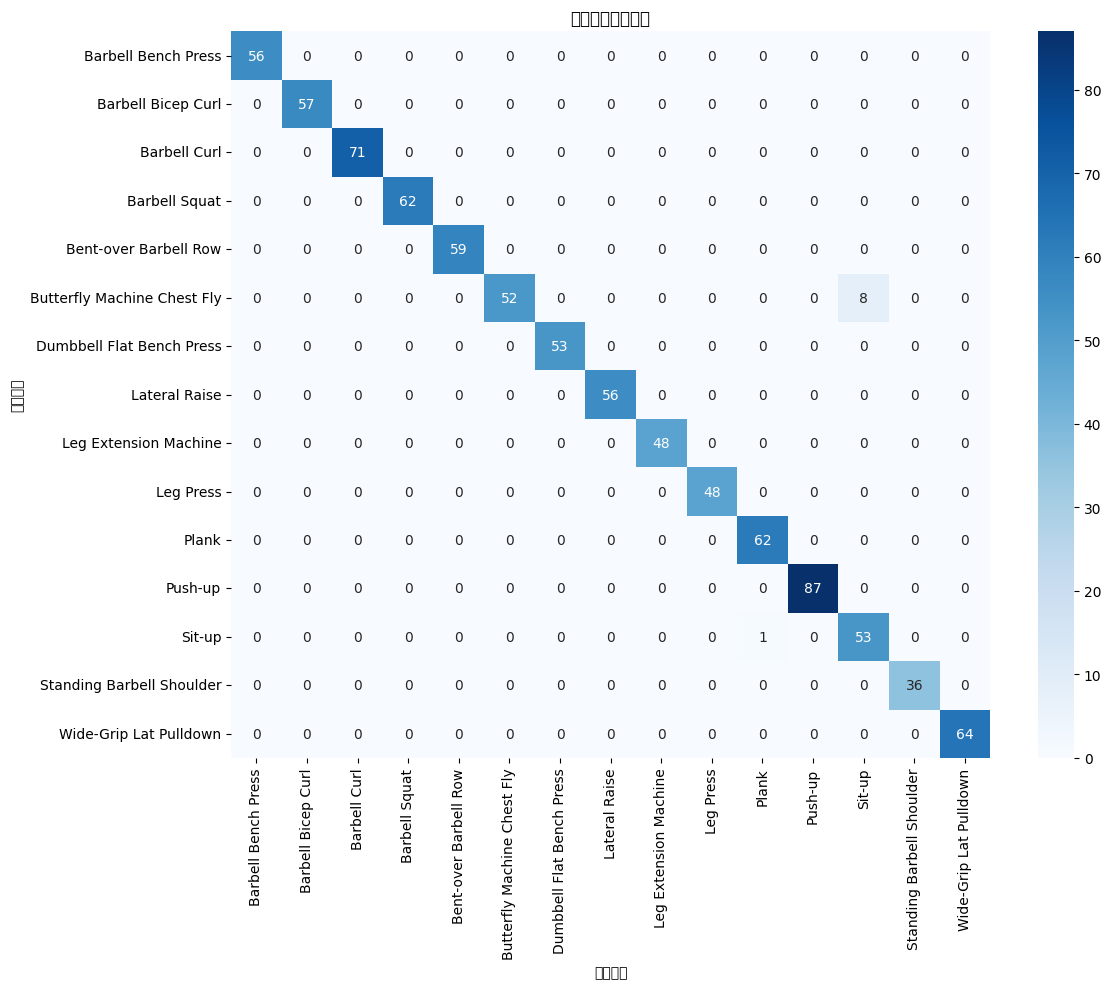

动作分类报告：
                             precision    recall  f1-score   support

        Barbell Bench Press       1.00      1.00      1.00        56
         Barbell Bicep Curl       1.00      1.00      1.00        57
               Barbell Curl       1.00      1.00      1.00        71
              Barbell Squat       1.00      1.00      1.00        62
      Bent-over Barbell Row       1.00      1.00      1.00        59
Butterfly Machine Chest Fly       1.00      0.87      0.93        60
  Dumbbell Flat Bench Press       1.00      1.00      1.00        53
              Lateral Raise       1.00      1.00      1.00        56
      Leg Extension Machine       1.00      1.00      1.00        48
                  Leg Press       1.00      1.00      1.00        48
                      Plank       0.98      1.00      0.99        62
                    Push-up       1.00      1.00      1.00        87
                     Sit-up       0.87      0.98      0.92        54
  Standing Barbell Should

In [ ]:
# Create and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN action classification: {accuracy:.2f}")

# Generate the confusion matrix and evaluate each class
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Action Classification Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

# Print the classification report (including precision, recall, F1-score)
print("Action Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [ ]:
# save the action classification model
joblib.dump(knn, 'action_classification_model.pkl')

['action_classification_model.pkl']